<a href="https://colab.research.google.com/github/sidhu2690/CogniXis/blob/main/05_ViT_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

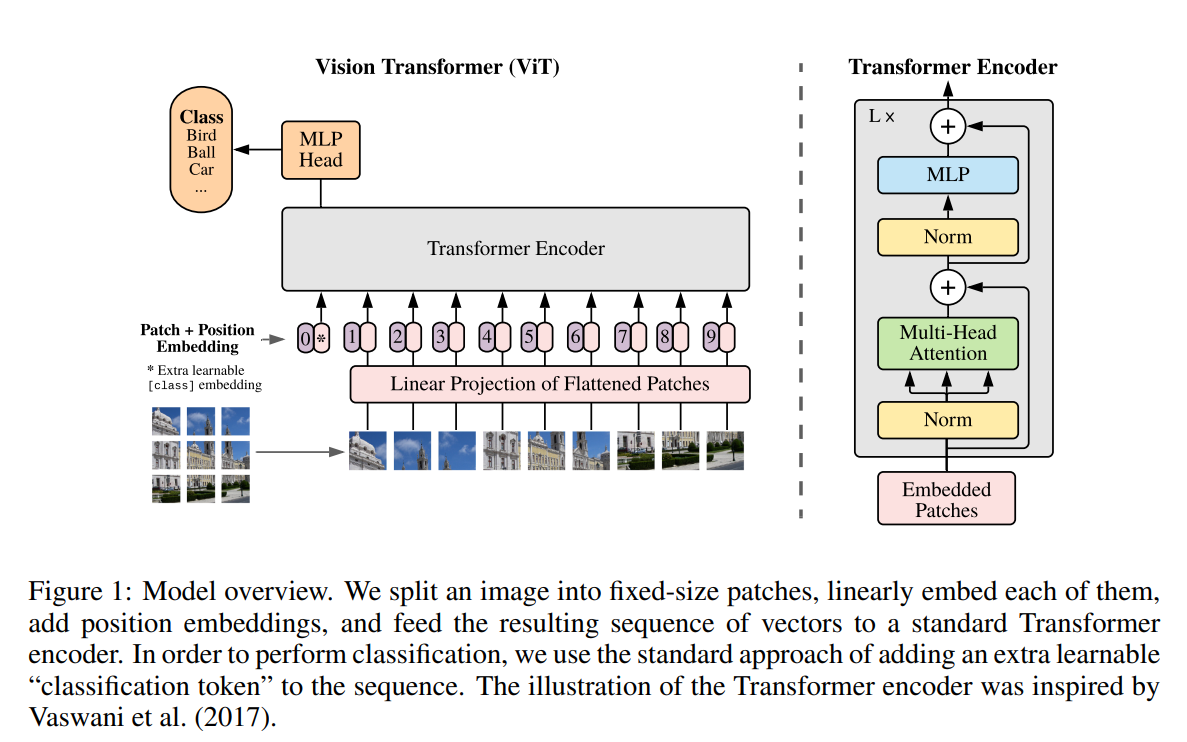

\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

# Splitting data into patches and creating class, position and patch embedding

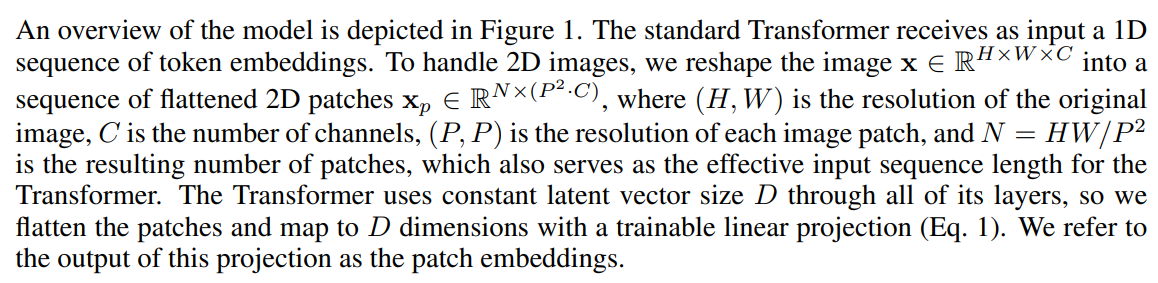

- Input shape: $H \times W \times C$ (height $\times$ width $\times$ color channels
- Output shape: $N \times\left(P^2 \cdot C\right)$
- $\mathrm{H}=$ height
- W = width
- $\mathrm{C}=$ color channels
- $\mathrm{P}=$ patch size
- $\mathrm{N}=$ number of patches $=($ height * width $) / \mathrm{p}^{\wedge} 2$
- $\mathrm{D}=$ constant latent vector size $=$ embedding dimension (see Table 1)

# Data for classification

In [4]:
!wget -q https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip -O pizza_steak_sushi.zip
!unzip -q pizza_steak_sushi.zip -d ./data/
!pip install -q cognixis

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from cognixis import summary
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [6]:
device= "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
train_dir="/content/data/train"
test_dir=  "/content/data/test"

In [8]:
data_transforms=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std= [0.2, 0.2, 0.2])
])

In [9]:
train_data=datasets.ImageFolder(root=train_dir, transform= data_transforms)
test_data= datasets.ImageFolder(root=test_dir, transform= data_transforms)

In [10]:
train_loader=DataLoader(train_data, batch_size= 32, shuffle= True)
test_loader= DataLoader(test_data, batch_size= 32, shuffle= True)

# Embeddings
 At first, we need to make this part: the embeddings. This has three parts:

1. Patch Creation and Flattening:
   - The input image is divided into smaller, fixed-size patches.
   - Each patch is converted into a tensor and flattened into a one-dimensional vector.
   - This step transforms the image into a sequence of vectorized patches.
2. Adding the [CLS] Token:
   - A special classification token (denoted as [CLS] or `*`) is prepended to   
     the sequence.
   - This token will represent the overall context of the image.

3. Positional Encoding:
   - Positional encodings are added to all embeddings, including the [CLS]
     token.
   - These encodings retain the spatial relationships of the image within the
     sequence.

The result is a set of embeddings ready for processing by the transformer model.


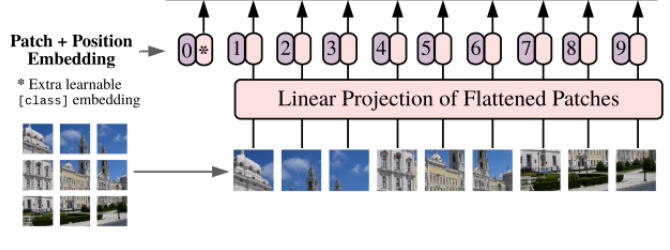

In [75]:
class Embedding(nn.Module):
    def __init__(self, width, height, in_channels, patch_size, embedding_dim):
        super().__init__()

        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.width = width
        self.height = height

        if width % patch_size != 0 or height % patch_size != 0:
            raise ValueError(
                f"Image dimensions ({width}, {height}) must be divisible by patch size {patch_size}."
            )

        self.Patch_embedding = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )
        self.flatten = nn.Flatten(2)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))  # Remove batch dimension
        self.position_embedding = nn.Parameter(
            torch.randn(1, (width // patch_size) * (height // patch_size) + 1, embedding_dim)  # Remove batch dimension
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        if width % self.patch_size != 0 or height % self.patch_size != 0:
            raise ValueError(
                f"Input dimensions ({height}, {width}) are not divisible by patch size {self.patch_size}."
            )
        if channels != self.in_channels:
            raise ValueError(
                f"Input channels ({channels}) do not match expected channels ({self.in_channels})."
            )

        z = self.Patch_embedding(x)
        z = self.flatten(z)
        z = z.permute(0, 2, 1)

        class_tokens = self.class_embedding.expand(batch_size, -1, -1)
        z = torch.cat((class_tokens, z), dim=1)

        z = z + self.position_embedding.expand(batch_size, -1, -1)

        return z

In [84]:
Embeddings= Embedding( width= 224, height= 224, in_channels= 3, patch_size= 16, embedding_dim= 768)
summary(Embeddings, input_shape=[32, 3, 224, 224], depth=2)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Embedding                                [32, 3, 224, 224]         [32, 197, 768]            152,064                   True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
├─Flatten: 1-2                           [32, 768, 14, 14]         [32, 768, 196]            --                        --
Total params: 742,656
Trainable params: 742,656
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.70
Input size (MB): 19.27
Forward/backward pass size (MB): 38.54
Params size (MB): 2.36
Estimated Total Size (MB): 60.17

# The Encoder
Encoder class defines a transformer encoder block with two main components: multihead self-attention and a feed-forward MLP. The block includes LayerNorm, residual connections, and dropout for regularization.

Arguments:
- embedding_dim (int): The dimensionality of the input embeddings.
- num_heads (int): The number of attention heads in the multihead attention layer.
- attn_dropout (float): Dropout probability for attention weights.
- mlp_size (int): Hidden layer size in the MLP.
- mlp_dropout (float): Dropout probability for the MLP layers.

In the forward pass:
1. The input is first normalized (LayerNorm) before passing through the multihead self-attention layer. The attention output is added to the input (residual connection).
2. The output is normalized again and passed through an MLP, followed by another residual connection.

The output tensor retains the shape of the input tensor.


In [85]:
class Encoder(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 num_heads: int,
                 attn_dropout: float = 0.1,
                 mlp_size: int = 2048,
                 mlp_dropout: float = 0.1):

        super().__init__()

        self.layernorm1 = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

        # MLP Block
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(p=mlp_dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(p=mlp_dropout)
        )

        self.layernorm2 = nn.LayerNorm(normalized_shape=embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        z = self.layernorm1(x)
        attn_output, _ = self.multihead_attn(z, z, z, need_weights=False)
        z = attn_output + residual

        residual = z
        z = self.layernorm2(z)
        z = self.mlp(z)
        z = z + residual  #

        return z


In [86]:
Encoder_part=Encoder(embedding_dim= 768, num_heads= 12, attn_dropout= 0.1, mlp_size= 3072, mlp_dropout= 0.1)
summary(Encoder_part, input_shape=[32, 197, 768], depth= 3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Encoder                                  [32, 197, 768]            [32, 197, 768]            --                        True
├─LayerNorm: 1-1                         [32, 197, 768]            [32, 197, 768]            1,536                     True
├─MultiheadAttention: 1-2                [32, 197, 768]            [32, 197, 768]            2,362,368                 True
├─LayerNorm: 1-3                         [32, 197, 768]            [32, 197, 768]            1,536                     True
├─Sequential: 1-4                        [32, 197, 768]            [32, 197, 768]            --                        True
│    └─Linear: 2-1                       [32, 197, 768]            [32, 197, 3072]           2,362,368                 True
│    └─GELU: 2-2                         [32, 197, 3072]           [32, 197, 3072]           --                        --
│    

# ViT

ViT (Vision Transformer) implements a transformer model for image classification. It processes images by converting them into patches, embedding them, and passing them through a transformer encoder, followed by a classification head.

Arguments:
- img_size (int): Height and width of the input image (assumes square images).
- batch_size (int): Batch size for training or inference.
- in_channels (int): Number of input channels (e.g., 3 for RGB images).
- patch_size (int): Size of each patch (assumes square patches).
- embedding_dim (int): Dimension of the patch embeddings.
- mlp_size (int): Hidden layer size for the MLP in the encoder.
- num_heads (int): Number of attention heads in the encoder.
- attn_dropout (float): Dropout rate for the attention layer.
- mlp_dropout (float): Dropout rate for the MLP layers.
- num_classes (int): Number of output classes for classification.

In the forward pass:
1. The image is split into patches and embedded using the `Embedding` class.
2. The embeddings are passed through the transformer encoder (`Encoder` class).
3. The output of the [CLS] token is used as the representation for classification, passed through a classification head (MLP) to produce the final output.

The output tensor has the shape (batch_size, num_classes).


In [89]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int,
                 batch_size: int,
                 in_channels: int,
                 patch_size: int,
                 embedding_dim: int,
                 mlp_size: int,
                 num_heads: int,
                 attn_dropout: float,
                 mlp_dropout: float,
                 num_classes: int):

        super().__init__()

        if img_size % patch_size != 0:
            raise ValueError(f"Image size ({img_size}) must be divisible by patch size ({patch_size}).")

        self.embedding = Embedding(
            width=img_size,
            height=img_size,
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )

        self.encoder = Encoder(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropout
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        z = self.embedding(x)

        z = self.encoder(z)

        cls_token = z[:, 0]
        out = self.classifier(cls_token)

        return out


In [90]:
ViT_model= ViT(img_size= 224,
               batch_size= 32,
               in_channels= 3,
               patch_size= 16,
               embedding_dim= 768,
               mlp_size= 3072,
               num_heads= 12,
               attn_dropout= 0.1,
               mlp_dropout=0.1,
               num_classes=3).to(device)

In [93]:
summary(ViT_model, input_shape=[32, 3, 224, 224], depth=3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ViT                                      [32, 3, 224, 224]         [32, 3]                   --                        True
├─Embedding: 1-1                         [32, 3, 224, 224]         [32, 197, 768]            152,064                   True
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Flatten: 2-2                      [32, 768, 14, 14]         [32, 768, 196]            --                        --
├─Encoder: 1-2                           [32, 197, 768]            [32, 197, 768]            --                        True
│    └─LayerNorm: 2-3                    [32, 197, 768]            [32, 197, 768]            1,536                     True
│    └─MultiheadAttention: 2-4           [32, 197, 768]            [32, 197, 768]            2,362,368                 True
│    

Now we have to train the model

In [100]:
optimizer= torch.optim.SGD(ViT_model.parameters(), lr=0.0001)
loss= nn.CrossEntropyLoss()

In [101]:
from cognixis import train

In [102]:
train(ViT_model, train_loader, test_loader,loss_fn= loss, optimizer=optimizer,  epochs=30, device=device)

Epoch: 1/30 | Train Loss: 8.2632 | Train Accuracy: 34.67% | Test Loss: 3.1771 | Test Accuracy: 42.67%
Epoch: 2/30 | Train Loss: 8.2079 | Train Accuracy: 35.11% | Test Loss: 3.2230 | Test Accuracy: 41.33%
Epoch: 3/30 | Train Loss: 8.3017 | Train Accuracy: 35.56% | Test Loss: 3.2225 | Test Accuracy: 40.00%
Epoch: 4/30 | Train Loss: 8.1043 | Train Accuracy: 39.11% | Test Loss: 3.2544 | Test Accuracy: 41.33%
Epoch: 5/30 | Train Loss: 8.1352 | Train Accuracy: 39.56% | Test Loss: 3.2170 | Test Accuracy: 41.33%
Epoch: 6/30 | Train Loss: 8.1251 | Train Accuracy: 40.44% | Test Loss: 3.2197 | Test Accuracy: 41.33%
Epoch: 7/30 | Train Loss: 8.0502 | Train Accuracy: 40.89% | Test Loss: 3.2778 | Test Accuracy: 40.00%
Epoch: 8/30 | Train Loss: 8.0924 | Train Accuracy: 47.11% | Test Loss: 3.2575 | Test Accuracy: 37.33%
Epoch: 9/30 | Train Loss: 8.1526 | Train Accuracy: 50.22% | Test Loss: 3.2170 | Test Accuracy: 37.33%
Epoch: 10/30 | Train Loss: 8.2138 | Train Accuracy: 49.33% | Test Loss: 3.2337 | T

Although parameter tuning and preprocessing may be needed to achieve better accuracy, we have successfully written and executed the code. However, let's also try using a pretrained model, both with and without pretrained weights.

# Pretrained ViT with weights

In [105]:
pretrained_vit=torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)

In [107]:
for params in pretrained_vit.parameters():
  params.required_grad=False

In [114]:
pretrained_vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [115]:
pretrained_vit.heads= nn.Sequential(
    nn.Linear(768, 3)
)

In [116]:
summary(pretrained_vit, input_shape=[32, 3, 224, 224], depth=3)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 3]                   768                       True
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   True
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        True
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            7,087,872                 True
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768]        

In [118]:
optimizer= torch.optim.Adam(pretrained_vit.parameters(), lr= 0.01)

In [119]:
train(pretrained_vit, train_loader, test_loader, loss, optimizer, epochs= 10, device=device)

Epoch: 1/10 | Train Loss: 15.6745 | Train Accuracy: 38.22% | Test Loss: 7.7719 | Test Accuracy: 25.33%
Epoch: 2/10 | Train Loss: 14.6707 | Train Accuracy: 35.11% | Test Loss: 3.5222 | Test Accuracy: 33.33%
Epoch: 3/10 | Train Loss: 10.9036 | Train Accuracy: 32.00% | Test Loss: 3.5080 | Test Accuracy: 41.33%
Epoch: 4/10 | Train Loss: 10.6823 | Train Accuracy: 32.89% | Test Loss: 5.2906 | Test Accuracy: 33.33%
Epoch: 5/10 | Train Loss: 10.6433 | Train Accuracy: 30.22% | Test Loss: 6.7077 | Test Accuracy: 33.33%
Epoch: 6/10 | Train Loss: 14.2760 | Train Accuracy: 34.67% | Test Loss: 5.6166 | Test Accuracy: 41.33%
Epoch: 7/10 | Train Loss: 13.6827 | Train Accuracy: 35.11% | Test Loss: 6.0085 | Test Accuracy: 33.33%
Epoch: 8/10 | Train Loss: 12.2474 | Train Accuracy: 31.56% | Test Loss: 7.9484 | Test Accuracy: 25.33%
Epoch: 9/10 | Train Loss: 15.5082 | Train Accuracy: 32.00% | Test Loss: 3.3859 | Test Accuracy: 41.33%
Epoch: 10/10 | Train Loss: 12.4331 | Train Accuracy: 30.67% | Test Loss: 

# ViT without weights

In [131]:
Model=torchvision.models.vit_b_16(weights=None).to(device)

In [135]:
Model.heads= nn.Sequential(
    nn.Linear(768, 3)
)

In [133]:
train(Model, train_loader, test_loader, loss, optimizer, epochs= 10, device=device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 4165 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 344.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Cuda oombichu